In [292]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl
import infomeasure as im
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [293]:
def sample_from_pdf_2d(pdf, x_bounds, y_bounds, n_samples):
    samples = []
    xmin, xmax = x_bounds
    ymin, ymax = y_bounds
    
    # Find max of pdf in bounding box (or approximate)
    xs = np.linspace(xmin, xmax, 200)
    ys = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[pdf((x, y)) for x in xs] for y in ys])
    M = Z.max()  # Upper bound
    
    while len(samples) < n_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        u = np.random.uniform(0, M)
        if u < pdf(np.array((x, y))):   # accept
            samples.append([x, y])
    return np.array(samples)

In [294]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
# Discretize the search space into 100-by-100 mesh grids
num_grid = 256
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)
pdf_vals = pdf(grids)


In [295]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point
from shapely.ops import clip_by_rect

def plot_voronoi(centroids, bounds=(0,1,0,1)):
    """
    Plot Voronoi diagram for given centroids, clipped to [0,1]^2.
    
    Args:
        centroids: array (N,2)
        bounds: (xmin, xmax, ymin, ymax)
    """
    xmin, xmax, ymin, ymax = bounds
    
    # Compute Voronoi tessellation
    vor = Voronoi(centroids)
    
    # Bounding box polygon
    box = Polygon([
        (xmin, ymin), (xmax, ymin),
        (xmax, ymax), (xmin, ymax)
    ])
    
    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    
    # Draw clipped Voronoi cells
    for region_idx in vor.point_region:
        region = vor.regions[region_idx]
        if not region or -1 in region:  # skip infinite regions
            continue
        polygon = Polygon([vor.vertices[i] for i in region])
        clipped = polygon.intersection(box)
        if not clipped.is_empty:
            x, y = clipped.exterior.xy
            ax.fill(x, y, alpha=0.3, edgecolor="black")
    
    # Draw centroids
    ax.scatter(centroids[:,0], centroids[:,1], c="red", s=30, label="Centroids")
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal")
    ax.legend()
    ax.set_title("Voronoi diagram clipped to [0,1]^2")
    plt.show()


In [296]:
mu_samples = np.load(r"C:\Users\prass\Documents\ERgodclean\Ergodic_control\basis\Indicator\mu_samples.npy")

In [297]:
N = 16**2
idx = np.random.choice(mu_samples.shape[0], size=N, replace=False)
centroids = mu_samples[idx]

2025-08-22 17:37:30,692 |  WARNING | legend.py:1236 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


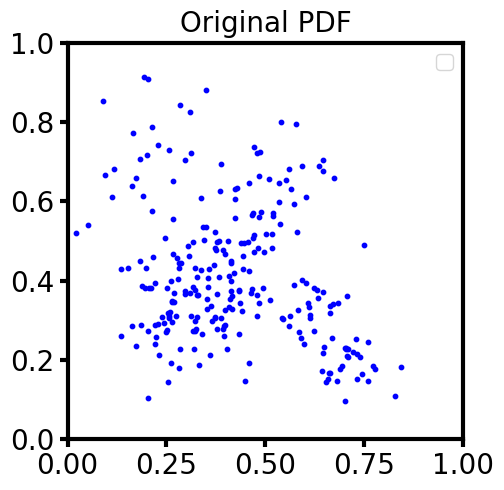

In [298]:
#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(centroids[:, 0], centroids[:,1], s=10, color='blue')
#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()

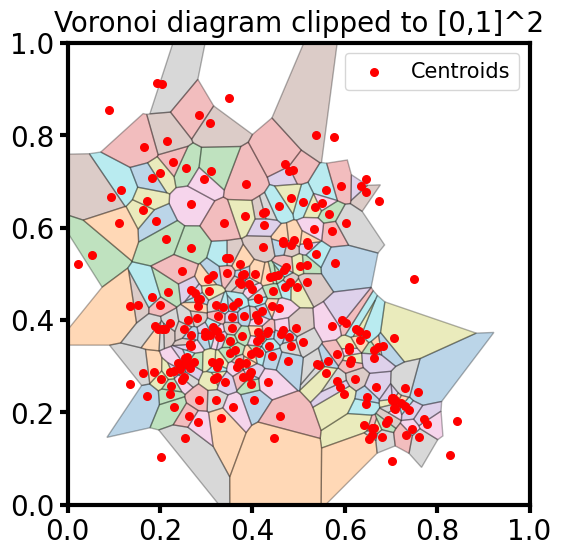

In [299]:
plot_voronoi(centroids)

In [300]:
import numpy as np
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point
from shapely.ops import clip_by_rect

def voronoi_cells(centroids, bounds=(0,1,0,1)):
    """
    Construct Voronoi cells clipped to bounding box.
    Returns list of shapely Polygons (cells).
    """
    xmin, xmax, ymin, ymax = bounds
    vor = Voronoi(centroids)
    box = Polygon([(xmin,ymin),(xmax,ymin),(xmax,ymax),(xmin,ymax)])
    
    cells = []
    for region_idx in vor.point_region:
        region = vor.regions[region_idx]
        if not region or -1 in region:
            cells.append(None)  # infinite region
            continue
        polygon = Polygon([vor.vertices[i] for i in region])
        clipped = polygon.intersection(box)
        if not clipped.is_empty:
            cells.append(clipped)
        else:
            cells.append(None)
    return cells

def point_to_cells_distance(x, cells):
    """
    Compute distance from point x to each Voronoi cell.
    If x is inside a cell, distance is 0 for that cell.
    """
    point = Point(x)
    dists = []
    for cell in cells:
        if cell is None:
            dists.append(np.inf)
        else:
            dists.append(point.distance(cell))
    return np.array(dists)

# Example usage
cells = voronoi_cells(centroids)

x = np.array([0.5, 0.5])
distances = point_to_cells_distance(x, cells)

print("Distances from point", x, "to each Voronoi cell:")
print(distances)


Distances from point [0.5 0.5] to each Voronoi cell:
[0.2025    inf 0.0705 0.0109 0.1813 0.2779 0.1671 0.0595 0.2744 0.3205
 0.2204 0.1678 0.1791 0.3001    inf 0.1373 0.2647 0.1887 0.2614 0.3032
 0.2668 0.3937    inf 0.127  0.2147 0.2128 0.2733 0.1007 0.1184 0.3355
 0.4465 0.2037 0.0327 0.3207 0.3039 0.0511 0.372  0.2254 0.1382 0.2138
 0.1656 0.1964 0.358  0.1308 0.3333 0.3062 0.3416 0.3328 0.3643 0.0822
 0.4258 0.262  0.1562 0.2653 0.0692 0.3586 0.1562 0.2118 0.4026 0.2366
 0.1215 0.3242 0.1557 0.237  0.2854 0.1518 0.2532 0.3118 0.3393 0.2371
 0.3157 0.0099 0.1611 0.2865 0.336  0.3452 0.0121 0.2274 0.3323 0.4195
 0.2212 0.1623 0.1759 0.3953 0.2132 0.3612 0.0871 0.2994 0.2584 0.2882
 0.1433 0.3555 0.1753 0.2181 0.3444 0.3626 0.113  0.0419 0.0036 0.3157
 0.4095 0.3416 0.1161 0.1656 0.1782 0.1576 0.2395 0.1949 0.2955 0.3573
 0.3385 0.3258 0.0126 0.2415 0.3163 0.2186 0.1792 0.1937 0.2118 0.0975
 0.0833 0.319  0.3027 0.2483 0.0762 0.2007 0.1409    inf    inf 0.2623
 0.0038 0.2306 0.1248 0.

In [301]:
from shapely.ops import nearest_points
from shapely.geometry import Point

def nearest_points_in_cells(x, cells):
    """
    For each Voronoi cell, compute the nearest point in the cell to x.
    If x is inside a cell, returns x itself.
    """
    p = Point(float(x[0]), float(x[1]))
    nearest_pts = []
    for cell in cells:
        if cell is None or cell.is_empty:
            nearest_pts.append([1000000, 1000000])
            continue
        if not cell.is_valid:
            cell = cell.buffer(0)  # fix invalid polygon
        try:
            q, r = nearest_points(p, cell)
            nearest_pts.append([r.x, r.y])
        except Exception:
            # fallback if GEOS still fails
            nearest_pts.append([1000000, 1000000])
    return np.array(nearest_pts)



In [302]:
x = np.array([0.0, 0.0])
nearest_pts = nearest_points_in_cells(x, cells)
x = np.array([0.5, 0.5])
nearest_pts2 = nearest_points_in_cells(x, cells)

2025-08-22 17:37:31,750 |  WARNING | legend.py:1236 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


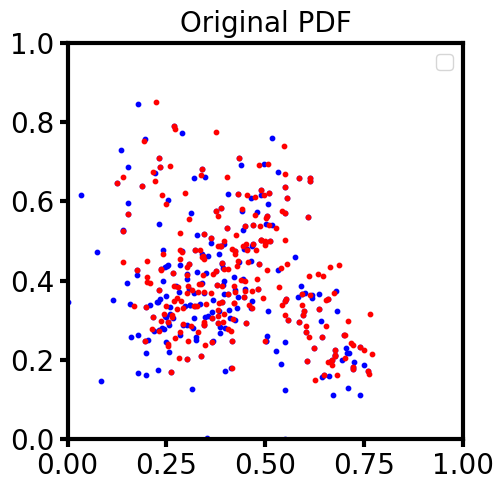

In [303]:

#mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.scatter(nearest_pts[:, 0], nearest_pts[:,1], s=10, color='blue')
ax.scatter(nearest_pts2[:, 0], nearest_pts2[:,1], s=10, color='red')

#ax.scatter(mu_samples[::10, 0], mu_samples[::10, 1], s=10, color='green')
ax.legend(loc=1)
plt.show()
plt.close()


In [304]:
tree = cKDTree(centroids)
labels = tree.query(mu_samples)[1]
target_probs = np.zeros(len(centroids))
for i in range(len(centroids)):
    target_probs[i] = np.mean(labels == i)


In [305]:
dt_emp = 0.01
tsteps = 100001
dt = dt_emp
ud = 0.2

def step(xt, ut):
    return xt + dt * ut
xt = np.array([0.5, 0.5])
x_traj = np.zeros((tsteps, 2))
traj_counts = np.zeros(N)
metric_log = []
for t in range(tsteps):
    # 1. Assign xt to nearest Voronoi centroid
    dists = np.linalg.norm(centroids - xt, axis=1)
    cell_idx = np.argmin(dists)
    #cell_idx = tree.query(xt)[1]
    traj_counts[cell_idx] += 1
    
    lambda_g = traj_counts / (t+1)
    e = (target_probs - lambda_g)
    e = np.maximum(0.0, e) 
    sigma = 0.05
    epsilon = 1e-12
    projections = nearest_points_in_cells(xt, cells)
    vectors = projections - xt
    dist2 = np.sum(vectors**2, axis=1) + epsilon
    #dists = point_to_cells_distance(xt, cells)
    weights = np.exp(-dist2**2 / sigma**2)
    #print(xt)
    direction = np.sum(e[:, None] * weights[:, None] * (vectors / dist2[:, None]), axis=0)
    ut = ud * direction / (np.linalg.norm(direction) + 1e-8)

    # 4. Step dynamics
    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    # 5. Metric
    metric = np.sum((target_probs - lambda_g)**2)
    metric_log.append(metric)

    if t % 1000 == 0 and t != 0:
        print(f"Step {t}, pos={xt}, metric={metric:.5f}")

fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[:36_000,0], x_traj[:36_000,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()
im.kld(x_traj[:36_000,:],mu_samples[:36_000,:], approach='metric')


KeyboardInterrupt: 

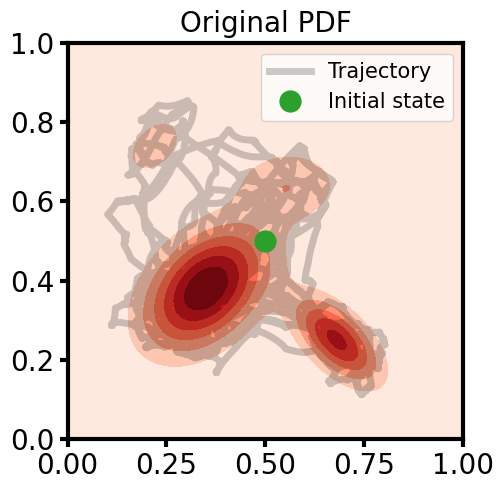

2.645184945648145

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[:36_000,0], x_traj[:36_000,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()
im.kld(x_traj[:36_000,:],mu_samples[:36_000,:], approach='metric')

In [ ]:
import numpy as np
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt

# ---------- BOUNDED VORONOI ON [0,1]^2 ----------
def bounded_voronoi(centroids, bounds=(0,1,0,1), pad=1.0):
    """
    Build a Voronoi diagram for given centroids and clip every cell to the box.
    Returns a list of shapely Polygons 'cells', one per centroid (same order).
    
    Args:
        centroids: (N,2) array
        bounds: (xmin, xmax, ymin, ymax)
        pad: mirror padding factor (>=1.0). Larger helps avoid -1 (infinite) regions.
    """
    xmin, xmax, ymin, ymax = bounds
    box = Polygon([(xmin,ymin), (xmax,ymin), (xmax,ymax), (xmin,ymax)])

    # Mirror points around the box to enforce boundedness
    w, h = (xmax - xmin), (ymax - ymin)
    shifts = [(dx*w, dy*h) for dx in (-pad, 0.0, pad) for dy in (-pad, 0.0, pad)]
    mirror_sets = []
    for sx, sy in shifts:
        if sx == 0.0 and sy == 0.0:
            continue
        mirror_sets.append(centroids + np.array([sx, sy]))
    mirrors = np.vstack(mirror_sets) if mirror_sets else np.empty((0,2))

    all_pts = np.vstack([centroids, mirrors]) if mirrors.size else centroids
    vor = Voronoi(all_pts)

    # Extract clipped polygon for each original centroid
    cells = []
    for i in range(len(centroids)):
        r_idx = vor.point_region[i]
        region = vor.regions[r_idx]
        if not region or (-1 in region):
            # If this still happens, increase 'pad'
            cells.append(box.buffer(0))  # fallback: whole box
            continue
        poly = Polygon([vor.vertices[j] for j in region])
        clipped = poly.intersection(box)
        # Ensure polygon validity (buffer(0) fixes tiny self-intersections)
        cells.append(clipped.buffer(0) if not clipped.is_empty else Polygon())
    return cells

# ---------- DISTANCE FROM A POINT TO EVERY CELL ----------
def point_to_cells_distance(x, cells):
    """
    True point-to-set distances: d_i(x) = min_{y in cell_i} ||x - y||_2
    Returns an (N,) array; zero for the cell that contains x (if any).
    
    Args:
        x: (2,) array-like
        cells: list of shapely Polygons (one per centroid)
    """
    p = Point(float(x[0]), float(x[1]))
    return np.array([p.distance(cell) if (cell is not None) else np.inf for cell in cells])

# ---------- OPTIONAL: BATCH VERSION (many query points) ----------
def points_to_cells_distance(X, cells):
    """
    Compute distances for many query points X of shape (T,2).
    Returns an array (T, N) where out[t, i] = dist(X[t], cell_i).
    (This loops over cells; fine for moderate N. For very large N or T,
     consider prefiltering candidates or parallelizing.)
    """
    T = len(X)
    out = np.zeros((T, len(cells)))
    for i, cell in enumerate(cells):
        if cell is None:
            out[:, i] = np.inf
        else:
            # shapely isn't vectorized; loop over points
            out[:, i] = [Point(xy[0], xy[1]).distance(cell) for xy in X]
    return out

# ---------- QUICK VISUAL CHECK ----------
def plot_bounded_voronoi(centroids, cells, bounds=(0,1,0,1)):
    xmin, xmax, ymin, ymax = bounds
    fig, ax = plt.subplots(figsize=(6,6))
    for poly in cells:
        if poly and not poly.is_empty:
            x, y = poly.exterior.xy
            ax.fill(x, y, alpha=0.25, edgecolor='k', linewidth=0.5)
    ax.scatter(centroids[:,0], centroids[:,1], c='red', s=20, zorder=3)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal'); ax.set_title('Bounded Voronoi on [0,1]^2')
    plt.show()

# -------------------- EXAMPLE --------------------
# centroids = np.random.rand(50, 2)
cells = bounded_voronoi(centroids, bounds=(0,1,0,1), pad=1.0)
#plot_bounded_voronoi(centroids, cells)
#x = np.array([0.5, 0.5])
#dists = point_to_cells_distance(x, cells)  # shape (N,)


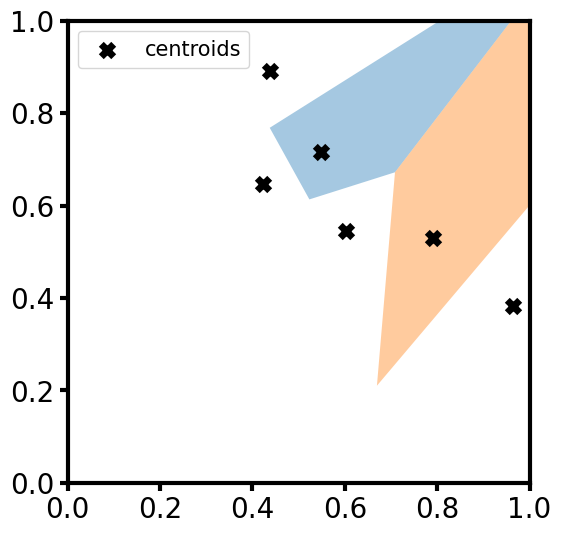

In [ ]:
import numpy as np

def tune_radii_by_sampling(centroids, 
                           r0=None, 
                           n_iter=200, 
                           samples_per_iter=20000, 
                           lam_ov=1.0, 
                           lam_gap=1.0, 
                           target_areas=None, 
                           lam_mass=0.0, 
                           step=0.1, 
                           rng=None):
    """
    Stochastic optimization of circle radii r to balance overlap vs coverage (and optional target areas).
    Domain is [0,1]^2.
    """
    rng = np.random.default_rng() if rng is None else rng
    N = len(centroids)
    r = np.full(N, 0.0) if r0 is None else r0.astype(float).copy()

    # Precompute centroid norms for speed (not strictly needed)
    for it in range(n_iter):
        X = rng.random((samples_per_iter, 2))  # uniform in [0,1]^2

        # Distances to each centroid
        # shape (S, N)
        d2 = ((X[:, None, :] - centroids[None, :, :])**2).sum(axis=2)
        inside = (d2 <= (r[None, :]**2))

        # --- Coverage (gap) term ---
        covered = inside.any(axis=1)
        gap_frac = 1.0 - covered.mean()  # fraction of uncovered samples

        # --- Overlap term (pairwise overlaps among disks) ---
        # #disks covering each point
        kcov = inside.sum(axis=1)  # shape (S,)
        # points covered by >=2 disks are "overlapped"
        overlap_frac = (kcov >= 2).mean()

        # --- Mass/area term per disk (optional; compares disk areas to targets) ---
        if target_areas is not None and lam_mass > 0:
            areas = np.pi * r**2
            mass_loss = np.sum((areas - target_areas)**2)
        else:
            mass_loss = 0.0

        loss = lam_ov * overlap_frac + lam_gap * gap_frac + lam_mass * mass_loss

        # --- Approximate gradient wrt r by finite differences (cheap stochastic) ---
        # perturb radii in small random directions and keep if better (1+1-ES style)
        direction = rng.normal(size=N)
        direction /= (np.linalg.norm(direction) + 1e-12)
        r_try = np.maximum(0.0, r + step * direction)

        # Re-evaluate loss quickly
        inside_try = (d2 <= (r_try[None, :]**2))
        covered_try = inside_try.any(axis=1)
        gap_frac_try = 1.0 - covered_try.mean()
        kcov_try = inside_try.sum(axis=1)
        overlap_frac_try = (kcov_try >= 2).mean()
        if target_areas is not None and lam_mass > 0:
            areas_try = np.pi * r_try**2
            mass_loss_try = np.sum((areas_try - target_areas)**2)
        else:
            mass_loss_try = 0.0
        loss_try = lam_ov * overlap_frac_try + lam_gap * gap_frac_try + lam_mass * mass_loss_try

        if loss_try < loss:  # accept step
            r = r_try
        else:
            # try opposite direction (very cheap safeguard)
            r_try2 = np.maximum(0.0, r - step * direction)
            inside_try2 = (d2 <= (r_try2[None, :]**2))
            covered_try2 = inside_try2.any(axis=1)
            gap_frac_try2 = 1.0 - covered_try2.mean()
            kcov_try2 = inside_try2.sum(axis=1)
            overlap_frac_try2 = (kcov_try2 >= 2).mean()
            if target_areas is not None and lam_mass > 0:
                areas_try2 = np.pi * r_try2**2
                mass_loss_try2 = np.sum((areas_try2 - target_areas)**2)
            else:
                mass_loss_try2 = 0.0
            loss_try2 = lam_ov * overlap_frac_try2 + lam_gap * gap_frac_try2 + lam_mass * mass_loss_try2
            if loss_try2 < loss:
                r = r_try2
        # optional: decay step
        step *= 0.995

    return r



In [ ]:
import numpy as np
from scipy.spatial import cKDTree

def safe_radii_half_nndist(centroids):
    tree = cKDTree(centroids)
    # k=2 (self + nearest neighbor); dist[:,1] is NN distance
    dists, _ = tree.query(centroids, k=2)
    r = 0.5 * dists[:, 1]
    return r
rads = safe_radii_half_nndist(centroids)

In [ ]:
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
# Discretize the search space into 100-by-100 mesh grids
num_grid = 256
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)
pdf_vals = pdf(grids)

2025-08-22 17:24:40,322 |  WARNING | legend.py:1236 | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


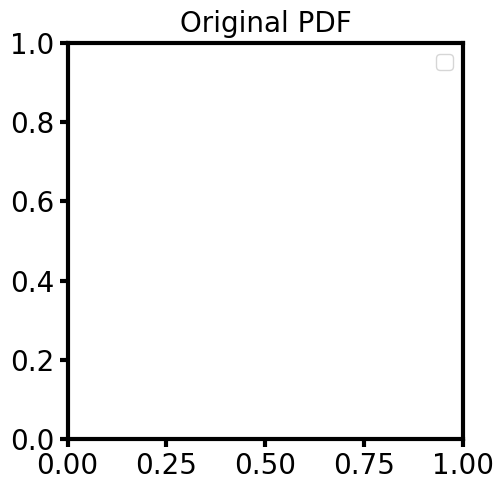

In [ ]:
mask = (np.linalg.norm(grids - centroids[0]) < .5)
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.scatter(grids[mask][:, 0], grids[mask][:,1], s=10, color='blue')
ax.legend(loc=1)
plt.show()
plt.close()

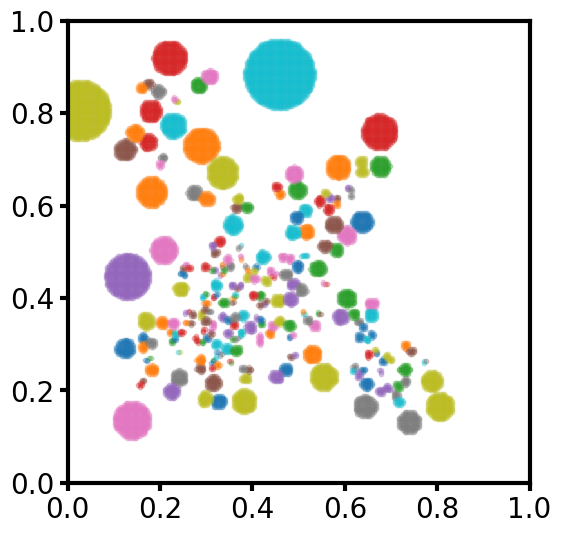

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
for i in range(len(centroids)):
    mask = (np.linalg.norm(grids - centroids[i], axis=1) < rads[i])
    ax.scatter(grids[mask][:,0], grids[mask][:,1], s=10, alpha=0.3)
    #ax.plot(centroids[i][0], centroids[i][1], 'x', color='black')
plt.show()


Step 1000, pos=[0.4488 0.3623], metric=0.32192
Step 2000, pos=[0.4138 0.4043], metric=0.20293
Step 3000, pos=[0.2665 0.3783], metric=0.14429
Step 4000, pos=[0.6731 0.245 ], metric=0.12453
Step 5000, pos=[0.6362 0.2609], metric=0.07943
Step 6000, pos=[0.3314 0.3125], metric=0.09877
Step 7000, pos=[0.4607 0.5023], metric=0.10197
Step 8000, pos=[0.422  0.3916], metric=0.08018
Step 9000, pos=[0.4516 0.4245], metric=0.08400
Step 10000, pos=[0.6452 0.2541], metric=0.06787
Step 11000, pos=[0.3574 0.3352], metric=0.07032
Step 12000, pos=[0.2463 0.2705], metric=0.07973
Step 13000, pos=[0.4088 0.3345], metric=0.07741
Step 14000, pos=[0.3167 0.2987], metric=0.07524
Step 15000, pos=[0.4088 0.5004], metric=0.07284
Step 16000, pos=[0.3584 0.3312], metric=0.06562
Step 17000, pos=[0.4101 0.4496], metric=0.06457
Step 18000, pos=[0.2674 0.3114], metric=0.06571
Step 19000, pos=[0.5157 0.4863], metric=0.06641
Step 20000, pos=[0.4887 0.5729], metric=0.05998
Step 21000, pos=[0.4233 0.3312], metric=0.06619
S

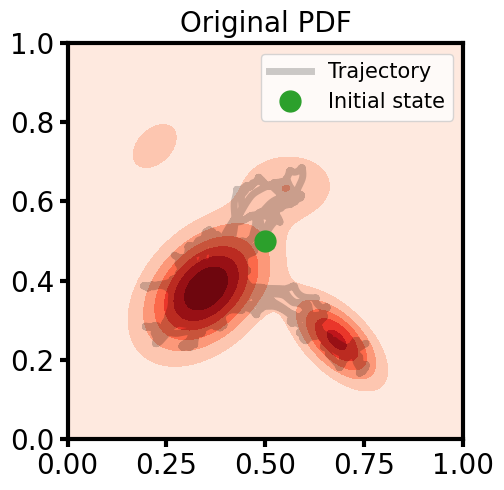

5.586794940665978

In [306]:
###### Fix target probs also better rads needed, in particular i can allow for intersection!!!

dt_emp = 0.01
tsteps = 100001
dt = dt_emp
ud = 0.2

def step(xt, ut):
    return xt + dt * ut
xt = np.array([0.5, 0.5])
x_traj = np.zeros((tsteps, 2))
traj_counts = np.zeros(N)
metric_log = []
for t in range(tsteps):
    # 1. Assign xt to nearest Voronoi centroid
    dists = np.linalg.norm(centroids - xt, axis=1)
    masks = dists < rads
    #cell_idx = tree.query(xt)[1]
    traj_counts[masks] += 1
    
    lambda_g = traj_counts / (t+1)
    e = (target_probs - lambda_g)
    e = np.maximum(0.0, e) 
    sigma = 0.05
    epsilon = 1e-12
    vectors = centroids - xt
    dist2 = (np.sum((vectors)**2, axis=1)) #### here i will have to set zero when within the set!
    #dists = point_to_cells_distance(xt, cells)
    weights = np.exp(-(dist2**2 + rads**2) / sigma**2)
    #print(xt)
    direction = np.sum(e[:, None] * weights[:, None] * (vectors / dist2[:, None]) * ~masks[:,None], axis=0)
    ut = ud * direction / (np.linalg.norm(direction) + 1e-8)

    # 4. Step dynamics
    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    # 5. Metric
    metric = np.sum((target_probs - lambda_g)**2)
    metric_log.append(metric)

    if t % 1000 == 0 and t != 0:
        print(f"Step {t}, pos={xt}, metric={metric:.5f}")

fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[:36_000,0], x_traj[:36_000,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()
im.kld(x_traj[:36_000,:],mu_samples[:36_000,:], approach='metric')
